# "Crystallography Open Database and torsion angle statistics with rdkit"
> "First steps to check how easy / feasible it is to extract torsion angle statistics from the COD"

- toc: true
- branch: master
- badges: true
- comments: true
- author: Peter Schmidtke
- categories: [rdkit, crystallography, small molecule xray, xray, database]
- image: images/toc-cod.png


## Context

When designing compounds in 3D, especially within the binding site, it is often very complicated to assess if what you've just designed actually makes sense. Is the molecule strained? Does it make ok or favourable interactions? Does it bump into the binding site somewhere? Especially when talking to medicinal chemists, they usually want to know whether their design passes all potential physical hurdles ... and while we're at it a prediction of the binding affinity would be nice and this in 1 second. 

Among all of these things to evaluate on a compound in 3D, the strain is something that can be either calculated (quantum mecanics, or force-field if you trust that) or compared to a set of reference compounds we know the structures of. 

A very popular reference database for small molecule conformations is the [CCDC CSD](https://www.ccdc.cam.ac.uk/solutions/csd-core/components/csd/). It contains more than a million small molecule crystal structures. It is widely used in pharma industry to assess various things ... among them: ligand strain. I won't enter the debate here whether the conformations observed in small molecule crystal structures are relevant and all the other debates on the use of such a database. 

The thing is, the CSD is not freely available. However, there's a free alternative available ... I guess the poor man's CSD and it's called COD for [Crystallography Open Database](http://www.crystallography.net/cod/index.php). It contains less structures than the CSD (466 000 by the time I'm writing this), that's for sure, but it's still maintained and people are depositing structures in there. The quality appears to be OK as well according to what I read so far, no tests done yet. 

Here I'll outline a few steps on how to get the COD and use rdkit to extract all torsion angles of all molecules - a long and bumpy ride. Here we go. 



## Get the COD

That's rather easy. You can simply retrieve cif or hkl files from their server using this here: 

`mkdir -p cif; rsync -av --delete rsync://www.crystallography.net/cif/ cif/`

This should run for a bit. 

## Parsing CIF in rdkit

The first hurdle is as usual linked to molecular formats. To the best of my knowledge no cif parser was ported yet to rdkit. I tried a few parsers (gemmi - no mol or other useable output yet, pdbccdutils -> only macromolecular cif files, I think) before ending up again with openbabel in the end. Let's stick with that for now.

Let's try to see what this looks like for a single cif file from the COD:


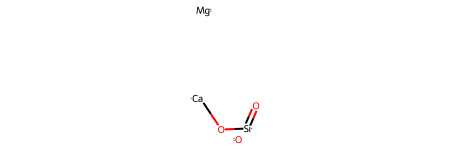

In [103]:
from rdkit import Chem
from openbabel import pybel
import py3Dmol
import dask
mol = next(pybel.readfile("cif", "../../cod/cif/1/00/00/1000007.cif")) 

molblock=mol.write("mol")    #write out as a molfile string and ship that now into rdkit

m = Chem.MolFromMolBlock(molblock,removeHs=False)
m

Well, that looks rather nasty. Let's check in 3D:

In [102]:
#collapse-hide

viewer = py3Dmol.view(width=300, height=300)
viewer.addModel(molblock, 'mol')
viewer.setStyle({"stick":{}})
viewer.zoomTo()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

So good news, cif parsing seems to work (at least on this particular example). The bad news, how can I get to relevant molecules in the COD? 

## Extracting relevant molecules from the COD

Thanks to researchgate I came across [this page](http://www.openmolecules.org/datawarrior/datafiles.html#cod) where they provide a datawarrior file of the content of the cod (at least a curated subpart of that). You can see that the COD contains organic, inorganic and metalorganic structures. 

![datawarrior screenshot](../images/datawarrior_example.png "Example screenshot from datawarrior")

As you might already observe on the screenshot above, there's a lot of noise (for drug discovery) in there. 

So how can we filter out only the organic ones? I checked the individual cif files, and no easy way to get to this classification ... would have been too easy. So two solutions - either take the prepared datawarrior file (which I would not prefer, because I'm dependent on somebody else doing this nice work during his free-time, Thomas Sander), or trial and error and identify organic compounds with a set of rules. Good thing is, I can use Thomas Sanders work (the datawarrior file) to check if the filter works or not (+ visual inspection).

The COD dump you can download via rsync is structured a bit like the PDB: with two levels of subfolders, numbered and 100 files max per subfolder. Basically I'll have to loop over all of this -> let's blow up the notebook ;) I'll loop over all molecules and try to run through sanitize. All failing molecules should not be added. Next I'm checking as well if there's at least a carbon atom in the structure (for a lot of them there isn't). I filter out metalorganics as well. Last I keep only molecules with more than 6 atoms. 

As this is a bit slow and can be easily put on several cpu's I'm doing that right here as well. I wanted to test how dask behaves on such a task. It's total overkill for what I'm doing here, but I want to see how the scheduling behaves on short living and often failing jobs (difficult to orchestrate, unless you handle it yourself in the code). 

Below you have a standalone python script (was not optimal in the notebook) to run all of this quick and dirty preparation. There are tons of rdkit & openbabel warnings popping out of that, as expected: 




In [ ]:
from rdkit import Chem
from openbabel import pybel
import glob
import pandas as pd
import os
import multiprocessing as mp
from wrapt_timeout_decorator import *
from rdkit import rdBase
rdBase.DisableLog('rdApp.error')
rdBase.DisableLog('rdApp.warning')

ob_log_handler = pybel.ob.OBMessageHandler()
ob_log_handler.SetOutputLevel(0)

carbon = Chem.MolFromSmarts("[#6]")



def is_transition_metal(at):
    n = at.GetAtomicNum()
    return (n>=22 and n<=29) or (n>=40 and n<=47) or (n>=72 and n<=79)


def write_output(filenames,outputname="out.sdf"):
    w = Chem.SDWriter(outputname)
    for filename in filenames:
        try:
            if os.stat(filename).st_size / (1024 * 1024)<2.0:
                mol = next(pybel.readfile("cif",str(filename))) 
                molblock=mol.write("mol")    #write out as a molfile string and ship that now into rdkit
                m = Chem.MolFromMolBlock(molblock,removeHs=False,sanitize=True)
                m.SetProp('COD',os.path.basename(filename).split(".")[0])
                w.write(m)
        except Exception:
            pass
    w.close()

def select_molecule(filename):

    blacklist=["../../cod/cif/2/31/17/2311717.cif","../../cod/cif/2/10/46/2104629.cif","../../cod/cif/2/10/59/2105953.cif"]
    if(filename not in blacklist):
        try:
            mol = next(pybel.readfile("cif",str(filename))) 
            molblock=mol.write("mol")    #write out as a molfile string and ship that now into rdkit
            m = Chem.MolFromMolBlock(molblock,removeHs=False,sanitize=True)
            
            if m is not None and len(m.GetSubstructMatches(carbon))>0 and m.GetNumAtoms()> 6  :
                
                if(True not in [is_transition_metal(atom) for atom in m.GetAtoms()]):
                    return filename
        except Exception:
            return None
        return None
    return None


if __name__ == '__main__':
    files=glob.glob('../../cod/cif/**/*.cif', recursive=True)
    n=0

    pool = mp.Pool(mp.cpu_count())
    results = pool.map(select_molecule, files)
    
    validresults=[el for el in results if el is not None]
    codids=[int(os.path.basename(filename).split(".")[0]) for filename in validresults]
    
    df = pd.read_table('/Users/peter/Downloads/COD_2020jun13.txt',  header=0)

    dwr=df["COD Number"]

    common=list(set(dwr) & set(codids))

    write_output(validresults)
    print("common molecules")
    print(len(common))

    import numpy as np
    print("in mine, not in datawarrior")
    intersect1=np.setdiff1d(codids,dwr)
    np.savetxt("out_intersect1.csv",intersect1.astype(int),delimiter=",",fmt='%i')
    print(len(intersect1))

    print("in datawarrior, not in mine")
    intersect2=np.setdiff1d(dwr,codids)
    np.savetxt("out_intersect2.csv",intersect2.astype(int),delimiter=",",fmt='%i')
    print(len(intersect2))

I finally decided to strip out the dask code and run it through multiprocessing. Anyhow, easy to set up and a quick discussion on that below as well!

## Dask & multiprocessing interlude

Before analyzing the results, let's briefly assess how dask performs here.
Dask enables us to run the code in a classical threaded, but also distributed mode, even on a local machine. As I have 12 cores's hanging in my MacPro I tested a distributed calculation. That is rather easy to set up. A bit like a multiprocessing Pool, but with the advantage that the functions are not 100% isolated (advantage or disadvantage, I let you decide ;)).  
The other nice thing (I didn't know about) is that dask (if installed through conda at least) comes with bokeh, a tool allowing you to do some monitoring of your jobs. It's not super advanced, but gives you an overview of the worker loads, the job queue and the overall advancement. So that's quite cool compared to being completely blind on what's happening in your queue. 

![dask screenshot](../images/dask_cod.png "Monitoring dask distributed computation using Bokeh")

I tested quite a range of combinations and ways to run this in dask (bag, compute, map .... ) and combinations of number of worker nodes vs threads. In the end, parallelization still isn't optimally spread over all cpu's, but I guess that's likely due to the fact that every calculation can range from immediate failure to runnning for a very long time. I guess, that on longer living and more stable jobs this is far more efficient. 

The most frustrating thing was that the script completely froze on a single job during the last 10% of the molecules. I narrowed down the issue to 3 molecules that openbabel naturally had issues with. When I say naturally, have a look at these: 

![issues with these cod's](../images/weird_cods.png "unprocessable with openbabel")

The nasty thing here is that I even tried to kill these freezing jobs with timeout decorators and such. Without success. Even a ctrl+c in a shell didn't kill the job ... only a kill -9 did. So in the end I kept the multiprocessing version here in the code and filtered out the three incriminating molecules ( by hand, but would be really interested to know how this can be handled in a more geeky way).






## Final filtered COD

Let's come back to the actual aim of this post. Extract torsion angle statistics from small molecule crystal structures. First let's have a look what molecules I have in common now with Datawarrior and which ones are different and whether the filter should / could be refined a bit. 

|                | obabel & rdkit | Datawarrior |
|----------------|----------------|-------------|
| obabel & rdkit | 78643          | 117674      |
| Datawarrior    | 117674         | 18344       |

The majority of retained molecules are in common with datawarrior, but I am, I guess still a bit permissive for now. I don't want to go too much into the analysis of differences here and now. Quickly checking the sd file (above 1Gb) with datawarrior gives a few ideas on what to filter out. I guess I can also use some of the published usual filters on top of that. 

![quick overview](../images/myselection.png "My selection of compounds - excerpt")



## Towards torsion angles

Now the next step is to identify whether there's enough data to gather some statistics on some typical torsion angles that you can encounter in druglike molecules. Fortunately Sereina Riniker & Greg Landrum already did [something a bit similar in the past with data from the CSD and the PDB](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654) to write the ETKDG (I hope I got that right) conformer generator for rdkit. 

The SI of that paper lists a bunch of smarts patterns describing such torsion angles. I'll blindly use these here to sieve through all molecules from the COD to see what I can get out of that. 
The smarts patterns are available [here](https://pubs.acs.org/doi/suppl/10.1021/acs.jcim.5b00654/suppl_file/ci5b00654_si_007.zip) - freely available ... unlike the paper behind it :(



In [3]:
import pandas as pd
from rdkit.Chem import rdMolTransforms

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import numpy as np
import urllib.parse

torsions=pd.read_table("../data/list_torsion_patterns.txt",header=None,usecols=[1])
suppl = Chem.SDMolSupplier('out.sdf',removeHs=False)
patterns=torsions[1][:3]

for torsionSmarts in patterns:
    print(torsionSmarts)
    angles=[]
    torsionQuery = Chem.MolFromSmarts(torsionSmarts)
    i=0
    #suppl.reset()
    for mol in suppl:
        i+=1
        if mol is None: continue
        conf=mol.GetConformer(0)
        matches = mol.GetSubstructMatches(torsionQuery)
        if(len(matches)>0):
            for match in matches:
                angle=rdMolTransforms.GetDihedralDeg(conf, match[0],match[1],match[2],match[3])
                angles.append(angle)


    if(len(angles)):
        smarts=urllib.parse.quote(torsionSmarts)
        img = mpimg.imread("https://smarts.plus/smartsview/download_rest?smarts="+smarts,format="png")

        fig = plt.figure(figsize=(10, 5))
        fig.add_subplot(121)
        plt.title('smarts pattern')
        plt.axis('off')
        plt.imshow(img)

        fig.add_subplot(122)
        plt.title('torsion angle histogram')
        
        #df = pd.DataFrame(angles,columns = [torsionSmarts])  
        
        plt.hist(np.array(angles),bins=36,range=[-180, 180])
        


![pattern1](../images/cod/res-1.png "First pattern statistics")
![pattern2](../images/cod/res-2.png "2nd pattern statistics")
![pattern3](../images/cod/res-3.png "3rd pattern statistics")

I'm only showing 3 smarts patterns here, but the code is written to run on all of the smarts patterns from the Riniker & Landrum paper. So feel free to adjust it to get the full results on your machine (to big for the notebook here ;).

As you can see, there is still a lot of errors when re-reading the molecules from the SD file ... so still a lot of curation to be done. Also, on fullerenes or graphene or other larger structures (that are still in there), we'll likely get a repeated overrepresentation of several torsion angles. So something to think about when normalizing all of this data in the end. 

In theory, the order of the smarts patterns in the file I used here should be comparable to torsion angles provided in the [S1.zip](https://pubs.acs.org/doi/suppl/10.1021/acs.jcim.5b00654/suppl_file/ci5b00654_si_002.zip) by both authors (fingers crossed). These histograms were generated on a filtered / curated CCDC CSD dataset (unlike my hairy monster dataset here).

![torsions](../images/torsion_angles_riniker.png)

The first thing to notice is that they calculated a dihedral between 0 and 360, I just took the angles popping out of rdkit (between -180 and 180). So a bit of a mindgame to compare both. On smarts patterns 1 and 3 we have peaks around 0, which coincides with the CSD results. It is interesting to see that there's a bit of data for smarts pattern 1 suggesting angles around 180° might be possible, though not favourable (again, more filtering and quality checks needed to confirm/discard that). 

Smarts pattern 2 doesn't coincide at all with results from the CSD however, which makes me worried ... a bit ;) 

## Debugging smarts pattern 2


In [100]:

pattern="[O:1]=[C:2]([N])!@;-[O:3]~[C:4]"
i=0
torsionQuery = Chem.MolFromSmarts(pattern)
for mol in suppl:
    i+=1
    if mol is None: continue
    conf=mol.GetConformer(0)
    matches = mol.GetSubstructMatches(torsionQuery)
    if(len(matches)):
        for match in matches:
                angle=rdMolTransforms.GetDihedralDeg(conf, match[0],match[1],match[2],match[3])
                #break
                print(angle)
                print(mol.GetProp("COD"))
    if(i>5000):
        break


178.94640626006364
7031170
-177.12326809469428
7039689
-179.7556421050122
7039689
-179.06730293018322
7039689


Here are 4 compounds where we calculate in theory wrong angles. Let's visualize the last one and check what dihedral angle we are actually calculating here

In [101]:
for mol in suppl:
    if str(mol.GetProp("COD"))==str(7039689):
        mol.GetSubstructMatches(torsionQuery)
        break

matches=mol.GetSubstructMatches(torsionQuery)
print(matches)
flat_list = [item for sublist in matches for item in sublist]
molblock=Chem.MolToMolBlock(mol)
viewer = py3Dmol.view(width=300, height=300)
viewer.addModel(molblock, 'mol')
viewer.setStyle({"stick":{}})
#viewer.setStyle({'serial':flat_list},{'stick':{'color': 'pink'}})
viewer.setStyle({'serial':flat_list},{'stick':{'color': 'pink'}})

viewer.zoomTo()

((1, 18, 4, 0, 19), (53, 70, 56, 52, 71), (105, 122, 108, 104, 123))


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

The matching atoms are coloured in pink here. 

From the substructure matches above, we can see that the smarts pattern matches 5 atoms, instead of 4. Including the nitrogen (the third atom matching here). In the end, this doesn't describe the bond or the torsion angle we want at all, thus the discrepancies in the results. 

# Conclusion

Alright, this turned out to be much messier than I thought. However, extracting statistics from the COD seems possible, even though there should be a lot careful curation steps integrated when doing something like that. I'll try to dig through the results during the next days and will try to report whether patterns published before using the CSD can be reproduced or not (to some extent). 

The steps outlined here should also provide a first automated pipeline to select relevant compounds from the COD for regular updates of the potentials - which I do hope will be helpful on the long run for some folks.



# PS

This post yielded a few reactions online, which is great. Thanks for Jesus Seco pointing out a [paper I missed, as usual, from Wolfgang Guba on a more refined set of torsion angle defining smarts patterns](https://pubs.acs.org/doi/10.1021/acs.jcim.5b00522), if you have access to that.  
Fortunately the SI is freely available and contains an [xml file](https://pubs.acs.org/doi/suppl/10.1021/acs.jcim.5b00522/suppl_file/ci5b00522_si_001.zip) with all the smarts patterns and even a traffic light (score) system for given ranges of angles. From my understanding in the description of the SI, only the histogram from the CSD was stripped from that file, but the statistics and preferred angles are derived from the CSD. So an excellent set to be used & to be compared to what we can extract from the COD.

```xml
<torsionRule smarts="[*:1]~[CX4:2]!@[n:3]~[*:4]">
      <angleList>
        <angle value="0.0" tolerance1="30.00" tolerance2="30.00" score="3.07"/>
        <angle value="60.0" tolerance1="30.00" tolerance2="30.00" score="3.55"/>
        <angle value="120.0" tolerance1="30.00" tolerance2="30.00" score="3.12"/>
        <angle value="180.0" tolerance1="30.00" tolerance2="30.00" score="3.54"/>
        <angle value="-60.0" tolerance1="30.00" tolerance2="30.00" score="3.65"/>
        <angle value="-120.0" tolerance1="30.00" tolerance2="30.00" score="3.1"/>
      </angleList>
</torsionRule>
```